In [250]:
# pip install librosa

In [251]:
#The output of this section is the CSV files with the data to be handle by the model
CREATE_CSV_FILES = True

In [252]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "Speaker_Train_File_otw2.csv"    # train  60
TEST_CSV_FILE = "Speaker_Test_File_otw2.csv"      # test 16

In [253]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
from matplotlib import cm
import pandas as pd
import librosa
import zipfile as zf
import csv
import os
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import csv
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.mixture import GaussianMixture

In [254]:
def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'  
    for i in range(1, 41):
        header += f' mfcc{i}'  #making headers of csv file
    header += ' label'     
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in os.listdir(soundFilesFolder):
        if filename.endswith('.wav'):
            number = f'{soundFilesFolder}/{filename}'
            y, sr = librosa.load(number, mono=True, duration=30)
            # remove leading and trailing silence
            y, index = librosa.effects.trim(y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 40)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

In [255]:
if (CREATE_CSV_FILES == True):
    extractWavFeatures("Speaker_Train_Data", TRAIN_CSV_FILE)
    extractWavFeatures("Speaker_Test_Data", TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

The features of the files in the folder Speaker_Train_Data will be saved to Speaker_Train_File_otw2.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'label']
End of extractWavFeatures
The features of the files in the folder Speaker_Test_Data will be saved to Speaker_Test_File_otw2.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13

In [256]:
#Reading a dataset and convert file name to corresbonding umnber
def preProcessData(csvFileName):
    header_name_list = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'label']
    print(csvFileName+ " will be preprocessed")
    data =  pd.read_csv(csvFileName)
#     data = pd.read_csv(csvFileName, skiprows=[1, 50]
    # we have 3 speakers: 
    # 0: ahmed
    # 1: belal
    # 2: micheal
    # 3: others
    filenameArray = data['filename'] 
    speakerArray = []
#     print(filenameArray)
    lengthOfSpeakerSamples = [0,0,0,0]
    for filename in filenameArray:
        #print(speaker)
        
        if "Michael" in filename:
            speaker = 0
        elif "Ahmed_Ashraf" in filename:
               speaker = 1
        elif "Belal" in filename:
            speaker = 2
        else:
            speaker = 3
        lengthOfSpeakerSamples[speaker]+=1
#         print(speaker)
        speakerArray.append(speaker)
    print(lengthOfSpeakerSamples)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    
    # for i in range(1, 41):
    #     data = data.drop([f'mfcc{i}'],axis=1)
#     data.shape
    print(data)
    print("Preprocessing is finished")
#     print(data['rmse'])
    
    return data

In [257]:
trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)

Speaker_Train_File_otw2.csv will be preprocessed
[98, 98, 100, 164]
     chroma_stft      rmse  spectral_centroid  spectral_bandwidth  \
0       0.337667  0.013404        1288.854671         1518.160524   
1       0.363886  0.009993        1222.905682         1460.351945   
2       0.275599  0.017168        1253.064143         1425.561648   
3       0.328698  0.018104        1198.371032         1500.572803   
4       0.364303  0.016585        1230.753953         1509.360576   
..           ...       ...                ...                 ...   
455     0.463336  0.032378        2005.132666         2148.827236   
456     0.441280  0.036381        1995.008828         2102.141285   
457     0.473269  0.030267        2145.997022         2248.043801   
458     0.468767  0.029816        2035.026065         2295.683010   
459     0.492761  0.030540        1812.283660         2075.019593   

         rolloff  zero_crossing_rate       mfcc1       mfcc2      mfcc3  \
0    2435.184420            

In [258]:
testData

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40,number
0,0.363886,0.009993,1222.905682,1460.351945,2157.293701,0.060233,-533.275513,126.323990,-5.393278,7.978744,...,9.847920,6.317571,2.457523,2.565717,-0.549338,-1.875484,-0.544401,-0.735906,-3.623948,3
1,0.364303,0.016585,1230.753953,1509.360576,2346.060131,0.049973,-485.665253,118.747414,-0.341144,14.197672,...,5.284318,7.979311,1.586594,2.322874,-2.114764,-1.790100,-0.101661,0.374472,-1.964005,3
2,0.340484,0.013829,1166.165148,1480.120271,2109.620577,0.050800,-504.032043,127.963150,2.349404,14.097299,...,3.478289,7.570534,2.271217,2.971118,0.029042,-0.701853,1.432102,0.208487,-3.162876,3
3,0.376980,0.015517,1387.471357,1609.152266,2662.320683,0.058013,-501.029175,112.742699,-15.422599,16.566858,...,4.116170,4.058353,1.534295,1.178144,-1.235215,1.639595,-3.728315,-2.688532,-1.636350,3
4,0.334539,0.015835,1276.583495,1634.214861,2637.144470,0.039693,-499.826416,122.048950,-1.920735,24.336123,...,10.266263,15.390595,9.012878,7.133364,0.400037,-0.292058,-4.085672,0.174606,5.223323,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.452994,0.042985,1814.419202,2068.841427,3832.619167,0.078574,-434.496246,112.916397,14.558284,19.883001,...,-2.922314,-5.019325,-4.526140,-4.617517,-4.716003,-5.655179,-4.306020,-4.753742,-3.474115,3
89,0.441280,0.036381,1995.008828,2102.141285,3936.269531,0.079740,-454.976349,100.731712,16.845055,20.575390,...,-4.975369,-5.245577,-4.434406,-6.300651,-4.143828,-4.713008,-3.595579,-6.107916,-2.948173,3
90,0.473269,0.030267,2145.997022,2248.043801,4451.083646,0.099725,-495.136993,88.907959,21.396997,20.355251,...,-5.482362,-4.185727,-4.232754,-5.212183,-2.876807,-3.669876,-4.746404,-4.561175,-1.552745,3
91,0.468767,0.029816,2035.026065,2295.683010,4361.697110,0.084806,-481.398621,98.354515,25.813599,17.567360,...,-3.813303,-4.131896,-3.526616,-5.430199,-3.725750,-3.397746,-3.936089,-5.319873,-2.225244,3


In [259]:
# Splitting the dataset into training, validation and testing dataset

X = trainData[trainData.columns[:-1]]
y = trainData[trainData.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41 )


# X_test = np.array(testData.iloc[:, :-1], dtype = float)
# y_test = testData.iloc[:, -1]

#X_test = X_val
#y_test = y_val
print("Y from training data:", y_train.shape)
print("Y from validation data:", y_test.shape)
print("Y from test data:", y_test.shape)

Y from training data: (345,)
Y from validation data: (115,)
Y from test data: (115,)


In [260]:
X_train

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40
60,0.261017,0.009401,1480.538582,1734.156075,3021.754395,0.054336,-527.379822,124.012558,3.236247,27.519722,...,13.632291,7.702515,5.994170,0.708639,4.362528,1.147077,0.804199,-4.202549,-3.854093,-1.928395
50,0.464720,0.033647,1899.736130,2792.827555,5076.387778,0.050864,-432.788391,101.008682,44.610096,15.285007,...,-1.315594,-2.847191,-2.249991,-1.878259,-3.965697,-1.291701,-3.924657,-1.180652,-2.673276,0.048690
304,0.467935,0.017347,1430.424490,1482.774857,2566.535055,0.113455,-471.486877,126.344299,-4.086764,2.318671,...,-4.533267,-5.820864,-6.382400,-5.633211,-6.236733,-1.456328,-2.859572,-2.229850,-4.067486,-3.589059
137,0.462244,0.016679,1468.525151,1554.180897,2531.760170,0.117715,-483.693146,124.867447,8.857064,6.332908,...,-8.878122,-5.637891,-1.700179,-3.200213,-6.804231,-5.553877,-5.411902,-4.793789,-3.803367,-5.117966
431,0.466601,0.017110,3045.704061,2109.412068,4657.601929,0.251655,-536.054932,88.414360,26.092743,17.790436,...,-1.812164,-1.470965,-4.070355,-2.782881,-3.195994,-3.376245,-3.729169,-3.053903,-5.108775,-4.847938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0.468224,0.012114,1302.220822,1412.247066,2411.966258,0.101046,-507.533325,149.121490,-2.787507,7.351168,...,-10.284672,-4.281495,-5.416245,-2.768503,-4.124503,-3.970565,-3.653801,-7.804039,-7.463355,-6.318465
80,0.233095,0.013263,1452.128721,1667.249900,2860.432703,0.053560,-524.692261,109.867340,-11.703888,23.269215,...,12.086721,16.698780,14.589094,7.858709,7.903023,4.237939,4.274377,1.433021,2.442412,3.489484
396,0.450568,0.013630,1125.354057,1321.384453,1946.651064,0.091269,-533.733765,146.751953,19.569595,12.294580,...,-7.381155,-6.439436,-2.918965,-5.515129,-7.434021,-4.749843,-3.298224,-5.399842,-6.428289,-4.843752
419,0.511380,0.012409,3510.286823,2192.046368,5299.829376,0.299585,-579.173218,70.966965,31.006523,15.146951,...,-3.156464,-1.083118,-3.111876,-3.144549,-3.615424,-2.641200,-4.044846,-2.808879,-3.269145,-3.985426


In [261]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
#scaler = StandardScaler()
#X_train = scaler.fit_transform( X_train )
#X_test = scaler.transform( X_test )
#X_train = normalize(X_train)
#X_test = normalize (X_test)
print("X from training data", X_train.shape)
print("X from test data", X_test.shape)

X from training data (345, 46)
X from test data (115, 46)


In [262]:

X_train.shape

(345, 46)

In [263]:
# gmm=GaussianMixture(n_components=6, max_iter=200 , covariance_type="diag" , n_init=3)
# gmm.fit(X_train)

In [264]:
#Create an object (model)
dtr1 = DecisionTreeClassifier(max_depth =7, random_state = 10)
#Fit (train) the model

#X_train = X_train.astype('int')

#y_train=y_train.astype('int')


dtr1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=10)

In [265]:
np.unique(y_train  ,return_counts = True)


(array([0, 1, 2, 3], dtype=int64), array([ 66,  70,  80, 129], dtype=int64))

In [266]:
np.unique(y_test  ,return_counts = True)


(array([0, 1, 2, 3], dtype=int64), array([32, 28, 20, 35], dtype=int64))

In [267]:
pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[3:9]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 60 to 448
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   spectral_bandwidth  345 non-null    float64
 1   rolloff             345 non-null    float64
 2   zero_crossing_rate  345 non-null    float64
 3   mfcc1               345 non-null    float64
 4   mfcc2               345 non-null    float64
 5   mfcc3               345 non-null    float64
dtypes: float64(6)
memory usage: 18.9 KB


In [268]:
# #plt the figure, setting a black background
# plt.figure(figsize=(30,10))
# #create the tree plot
# a = tree.plot_tree(dtr1,feature_names = list(['rmse', 'spectral_centroid', 'spectral_bandwidth', 
#                    'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 
#                    'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 
#                    'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 
#                    'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40']),
#                    class_names = ["0", "1","4"],
#                    rounded = True,
#                    filled = True,
#                    fontsize=14)
# #show the plot
# plt.show()

In [269]:
# data = preProcessData('Speaker_File.csv')
test_pred_decision_tree = dtr1.predict(X_test)

print(test_pred_decision_tree)
print(np.array(y_test))


[0 0 0 0 3 0 3 3 1 3 1 3 0 3 0 2 1 2 0 2 1 0 1 3 0 3 1 0 2 3 1 3 1 3 0 1 1
 0 0 3 3 1 3 0 1 2 2 1 0 2 1 1 0 1 3 0 0 0 1 1 3 2 2 3 2 0 0 0 0 2 1 3 0 0
 1 2 3 2 2 3 1 2 2 0 3 0 1 3 3 2 3 3 3 0 3 3 3 1 3 0 0 2 0 3 1 3 2 1 0 0 1
 1 1 0 1]
[0 0 0 1 3 0 3 3 1 3 1 3 0 3 0 2 1 2 0 2 1 0 1 3 0 3 1 0 2 3 1 0 1 1 0 1 1
 0 0 3 3 1 3 0 1 2 2 1 0 2 1 1 0 1 3 0 0 0 1 1 3 2 2 3 2 0 3 0 3 2 1 3 0 0
 1 2 3 2 2 0 1 2 2 0 3 0 1 3 3 2 3 3 3 3 3 3 3 1 3 0 0 2 2 3 3 3 2 1 0 0 3
 1 1 0 3]


In [270]:
y_test=y_test.astype('int64')

print("Accuracy:",metrics.accuracy_score(y_test, test_pred_decision_tree))

Accuracy: 0.9043478260869565


In [271]:
def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = dtr1.predict(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    # target_names = ["Marina", "Mohab", "Unknown"]
    print(classification_report(y_test_num, Y_pred))

Classification Report for Test Data

[[30  0  0  2]
 [ 1 26  0  1]
 [ 1  0 19  0]
 [ 3  3  0 29]]


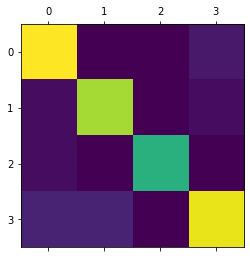


Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        32
           1       0.90      0.93      0.91        28
           2       1.00      0.95      0.97        20
           3       0.91      0.83      0.87        35

    accuracy                           0.90       115
   macro avg       0.91      0.91      0.91       115
weighted avg       0.91      0.90      0.90       115



In [272]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

In [275]:
# save the model to disk
import pickle
filename = 'voiceWithOthers.sav'
pickle.dump(dtr1, open(filename, 'wb'))


# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [276]:
loaded_model =pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.9043478260869565